<a href="https://colab.research.google.com/github/hapieharper/machinelearning11/blob/main/chest_xray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [3]:
import os, cv2
import numpy as np
import pandas as pd
from skimage.io import imread
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Dropout, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings("ignore")

In [4]:
train_dataset = '/content/drive/MyDrive/ML_교육/딥러닝/3일차/과제코드/chest_xray/train'
test_dataset = '/content/drive/MyDrive/ML_교육/딥러닝/3일차/과제코드/chest_xray/test'
val_dataset = '/content/drive/MyDrive/ML_교육/딥러닝/3일차/과제코드/chest_xray/val'
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

In [5]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_dataset,
    labels='inferred',
    color_mode='grayscale',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode = 'binary',
    seed = 42
)

test_dataset = tf.keras.utils.image_dataset_from_directory(
    test_dataset,
    labels='inferred',
    color_mode='grayscale',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    shuffle = False # f1스코어, auc 스코어 성능 저하 방지 (정답 데이터, 예측값 리스트 섞임 방지용)
)
val_dataset = tf.keras.utils.image_dataset_from_directory(
   val_dataset,
    labels='inferred',
    color_mode='grayscale',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode='binary',
    seed = 42
)


Found 4173 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 1059 files belonging to 2 classes.


In [6]:

model = Sequential([
    #리콜링에서 이미지 스케일 0~1로 고정
    Rescaling(1./255, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 1)),

    Conv2D(32, (3, 3), activation='relu'), #컨볼루젼레이어
    MaxPooling2D((2, 2)), #풀링
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    GlobalAveragePooling2D(), #2차원 데이터 1차원으로 변환
    Dense(512, activation='relu'), #활성화 함수 적용(복잡한 데이터 학습 O)
    Dropout(0.5), #신경망에 있는 일정 노드 확률적으로 제거해서 오버피팅 방지
    # 출력층
    Dense(1, activation='sigmoid') #이진분류라 sigmoid 사용
])
# 이 부분은 개념적으로 이해하기 어려워서 긁어왔습니닷..

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 150, 150, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 159,233 (622.00 KB)

 Trainable params: 159,233 (622.00 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer=Adam(learning_rate=1e-4), #학습률 지정
    loss='binary_crossentropy',
    metrics=['accuracy']

)

In [14]:
#4번 셀에서 데이터 불균형이 심해서 가중치 계산 코드 넣었어요

#train 데이터 셋의 레이블 개수 확인
labels = []

for _, label_batch in train_dataset:
    labels.extend(label_batch.numpy())

labels = np.array(labels)
# 정상 = 0, 폐렴 = 1
normal_count = np.sum(labels == 0)
pneumonia_count = np.sum(labels == 1)

print(f"Train Set: NORMAL (0) - {normal_count} | PNEUMONIA (1) - {pneumonia_count}")

# 가중치 계산 시작 || 전체 클래스 수 /(클래스 개수 * 클래스별 데이터 개수  )
total = normal_count + pneumonia_count
weight_for_0 = (1 / normal_count) * (total / 2.0)
weight_for_1 = (1 / pneumonia_count) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
print(f"Class Weights: {class_weight}")



Train Set: NORMAL (0) - 1073 | PNEUMONIA (1) - 3100
Class Weights: {0: np.float64(1.9445479962721341), 1: np.float64(0.6730645161290323)}


In [11]:
#모델 학습 시작
model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    class_weight=class_weight  # <- 계산된 가중치 적용
)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.3315 - loss: 0.6959 - val_accuracy: 0.3569 - val_loss: 0.6964
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 285ms/step - accuracy: 0.4275 - loss: 0.6602 - val_accuracy: 0.6789 - val_loss: 0.6215
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 40s 304ms/step - accuracy: 0.7733 - loss: 0.5121 - val_accuracy: 0.8555 - val_loss: 0.4350
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 287ms/step - accuracy: 0.8198 - loss: 0.4188 - val_accuracy: 0.8584 - val_loss: 0.3478
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 284ms/step - accuracy: 0.8363 - loss: 0.3970 - val_accuracy: 0.8612 - val_loss: 0.3327
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 36s 275ms/step - accuracy: 0.8474 - loss: 0.3718 - val_accuracy: 0.8659 - val_loss: 0.3162
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 37s 281ms/step - accuracy: 0.8596 - loss: 0.3397 - val_accuracy: 0.8706 - val_loss: 0.3098
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 39s 302ms/step - accuracy: 0.8530 - loss: 0.3

In [12]:
# 모델 전체적인 정확도 측정
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 116s 6s/step - accuracy: 0.7605 - loss: 0.4727
Test Loss: 0.3802
Test Accuracy: 81.73%


In [15]:
#모델 예측 시작

y_true_list = []
for images, labels in test_dataset:
    y_true_list.append(labels.numpy())

y_true = np.concatenate(y_true_list, axis=0).flatten()
y_pred_probs = model.predict(test_dataset).flatten()
y_pred = (y_pred_probs > 0.5).astype(int)
class_names = test_dataset.class_names

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 201ms/step


In [16]:

print(classification_report(y_true, y_pred, target_names=class_names))

              precision    recall  f1-score   support

      NORMAL       0.80      0.68      0.74       234
   PNEUMONIA       0.83      0.90      0.86       390

    accuracy                           0.82       624
   macro avg       0.81      0.79      0.80       624
weighted avg       0.82      0.82      0.81       624



In [17]:
print("AUC Score")
# AUC는 이진 레이블(y_pred)이 아닌 예측 확률(y_pred_probs)을 사용해야 합니다.
auc_score = roc_auc_score(y_true, y_pred_probs)
print(f"AUC Score: {auc_score:.4f}")

AUC Score
AUC Score: 0.9084


혼동행렬 비교


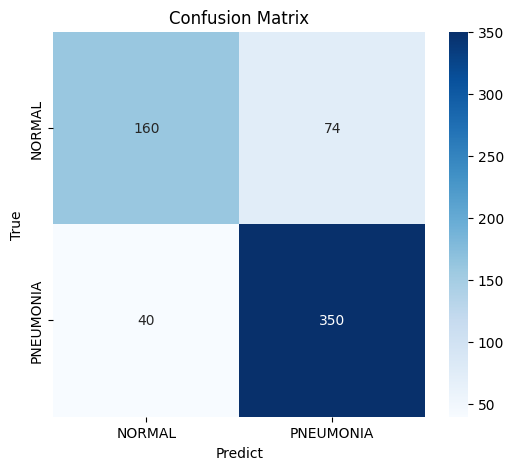

In [18]:
print("혼동행렬 비교")
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predict')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

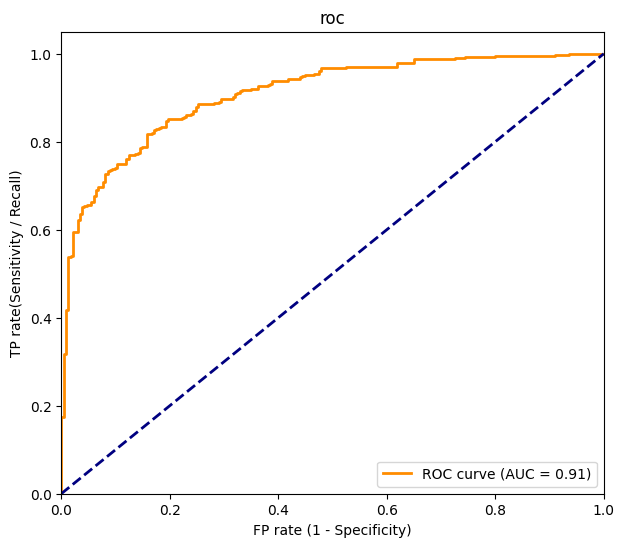

In [19]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)

plt.figure(figsize=(7, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FP rate (1 - Specificity)')
plt.ylabel('TP rate(Sensitivity / Recall)')
plt.title('roc')
plt.legend(loc="lower right")
plt.show()